In [27]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
from datetime import datetime
from google.colab import drive
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Independent project_2023 Summer/BacktestData/'
spread_path = '/content/drive/MyDrive/Colab Notebooks/Independent project_2023 Summer/NewSpread/'
trading_pairs = {'JBF':'3443','QWF':'2388','HCF':'2498','DBF':'2610','EHF':'1319','IPF':'3035','IIF':'3006','QXF':'2615','PEF':'5425','NAF':'3105'}

In [5]:
#Test if n days after start date given is valid.
def valid_date_n_days_later(start, dates, n):
    i = 1
    while i <= n:
        start = start + pd.DateOffset(days=1)
        if start in dates:
            i = i + 1
        if start > dates[-1]:
            return False
    return start

#Test if n days before start date given is valid.
def valid_date_n_days_before(start, dates, n):
    i = 1
    while i <= n:
        start = start - pd.DateOffset(days=1)
        if start in dates:
            i = i + 1
        if start < dates[0]:
            return False
    return start

#Benchmark strategy:

Only 1 lot of futures and 2 lots of stocks version.

In [74]:
pnl_dict = {}
for _ in tqdm(trading_pairs):
  spread_data = pd.read_csv(spread_path + _ + '.csv', index_col=0, parse_dates=True)
  spread = spread_data
  spread = spread.reset_index()
  spread['date'] = spread['time_stamp'].dt.date
  spread['time'] = spread['time_stamp'].dt.time
  spread = spread.set_index('time_stamp', drop = True)
  dates = list(set(pd.to_datetime(spread.date)))
  dates = sorted(dates)
  stock_data = pd.read_csv(data_path + 'stocks/' +trading_pairs[_] + '.csv', index_col=0, parse_dates=True)
  stock_data = stock_data.sort_index()
  futures_data = pd.read_csv(data_path + 'futures/' + _ + '.csv', index_col=0, parse_dates=True)
  #test = futures_data.loc[spread.index]
  futures_data = futures_data.sort_index()

  pnl_daily = {}

  #50 for test purpose
  #Time spot is end of 1 day before date(regarding threshold and mean), trade on date.
  for date in dates[50:-1]:
      #Using rolling mean as long term mean, data on the trading day is not included. To be tuned.
      rolling_window = 50
      train_date = valid_date_n_days_before(date, dates, rolling_window)
      end_date = valid_date_n_days_later(date, dates, 1)
      #After start_time all data is unknown.
      start_time = date + pd.DateOffset(hours=9,minute = 1)
      #Data on date not included.
      spread_historical_data = spread[train_date:date]
      #Long term mean and sd, for selecting threshold.
      sd = np.std(spread_historical_data['mid_quote'], axis=0)
      mean = spread_historical_data['mid_quote'].mean()

      upper = mean + 1 * sd
      lower = mean - 1 * sd

      #Stock and futures data
      stock_trade_data = stock_data[start_time:end_date]
      future_trade_data = futures_data[start_time:end_date]
      spread_ = spread[start_time:end_date]

      # position 1 for long spread, -1 for short spread, 0 for no position
      position = 0

      # net position in dollar
      net_position = 0

      # shares of stock
      stock_position = 0

      # shares of future
      future_position = 0

      #We have all data before timestamp.
      timestamp = start_time + pd.DateOffset(minutes=1)
      next_row = spread_.loc[spread_.index >= timestamp].iloc[0]
      timestamp = next_row.name
      while timestamp <= spread_.index[-1]:

        #Liquidate all position sharply at end of day of stock.
        if timestamp == spread_.index[-1]:
            stock_row = stock_trade_data.loc[stock_trade_data.index >= timestamp].iloc[0]
            future_row = future_trade_data.loc[future_trade_data.index >= timestamp].iloc[0]

            #Position = 1 means shorted spread. Liquidate neees to long stock, sell futures.
            if position == 1:
                  #1 position of futures matches 2 position of stock.
                  #print("1",net_position)
                  #print(timestamp,stock_row.ask_1_average,stock_position,future_position,future_row.bid_1_average)
                  net_position = net_position + stock_position * stock_row.ask_1_average + future_position * future_row.bid_1_average * 2
                  #print("1 after",net_position)
            #Position = -1 means longed spread. Liquidate neees to sell stock, buy futures.
            if position == -1:
                  net_position = net_position + stock_position * stock_row.bid_1_average + future_position * future_row.ask_1_average * 2
            break

        #Latest data stored in row
        row = stock_trade_data.loc[timestamp]
        spread_latest = spread_.loc[timestamp].mid_quote
        future_last_row = (future_trade_data.loc[future_trade_data.index <= timestamp]).iloc[-1]

        #Wait until next spread.
        future_next_row = future_trade_data.loc[spread_.loc[spread_.index > timestamp].iloc[0].name]
        stock_next_row = stock_trade_data.loc[future_next_row.name]

        #Open a position
        if stock_position == 0 and future_position == 0:
              if spread_latest >= upper:
                  if stock_next_row['bid_1_total'] >=2:
                      position = 1
                      stock_position = stock_position - 2
                      future_position = future_position + 1
                      net_position = net_position + stock_next_row['bid_1_average'] * 2 - future_next_row['ask_1_average'] * 1 * 2
                      timestamp = future_next_row.name
                      continue
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  # print(next_row.name)
                  timestamp = next_row.name
              elif spread_latest <= lower:
                  # print(1.2)
                  if stock_next_row['ask_1_total'] >=2:
                      position = -1
                      stock_position = stock_position + 2
                      future_position = future_position - 1
                      net_position = net_position - stock_next_row['ask_1_average'] * 2 + future_next_row['bid_1_average'] * 1 * 2
                      timestamp = future_next_row.name
                      continue
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  # print(next_row.name)
                  timestamp = next_row.name
              else:
                  # print(1.3)
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  # print(next_row.name)
                  timestamp = next_row.name

        #Already has a position
        else:
              if position == 1:
                  if spread_latest <= mean:
                      while stock_position != 0 or future_position !=0:
                          if stock_position != 0:
                              remained = min(stock_position + stock_next_row['ask_1_total'], 0)
                              net_position = net_position - stock_next_row['ask_1_average'] * (remained - stock_position)
                              stock_position = remained
                          if future_position != 0:
                              remained = max(future_position - future_next_row['bid_1_total'], 0)
                              net_position = net_position + future_next_row['bid_1_average'] * (future_position - remained) * 2
                              future_position = remained
                          timestamp = future_next_row.name
                          if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                              break
                          stock_next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                          timestamp = stock_next_row.name
                          future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                      next_row = spread_.loc[spread_.index >= timestamp].iloc[0]
                      timestamp = next_row.name
                  else:
                      next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                      timestamp = next_row.name
              elif position == -1:
                  if spread_latest >= mean:
                      while stock_position != 0 or future_position !=0:
                          if stock_position != 0:
                              remained = max(stock_position - stock_next_row['bid_1_total'], 0)
                              net_position = net_position + stock_next_row['bid_1_average'] * (stock_position - remained)
                              stock_position = remained
                          if future_position != 0:
                              remained = min(future_position + future_next_row['ask_1_total'], 0)
                              net_position = net_position - future_next_row['ask_1_average'] * (remained - future_position) * 2
                              future_position = remained
                          timestamp = future_next_row.name
                          if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                              break
                          stock_next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                          timestamp = stock_next_row.name
                          future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                      next_row = spread_.loc[spread_.index >= timestamp].iloc[0]
                      timestamp = next_row.name
                  else:
                      next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                      timestamp = next_row.name
              else:
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  timestamp = next_row.name
      pnl_daily[date] = -net_position
  # plot pnl
  pnl = pd.Series(pnl_daily)
  pnl_dict[_] = pnl

100%|██████████| 10/10 [22:58<00:00, 137.85s/it]


JBF 

156.5231706012839


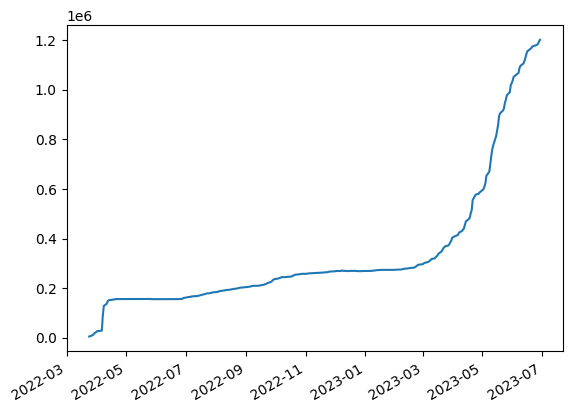

QWF 

261.49841938613895


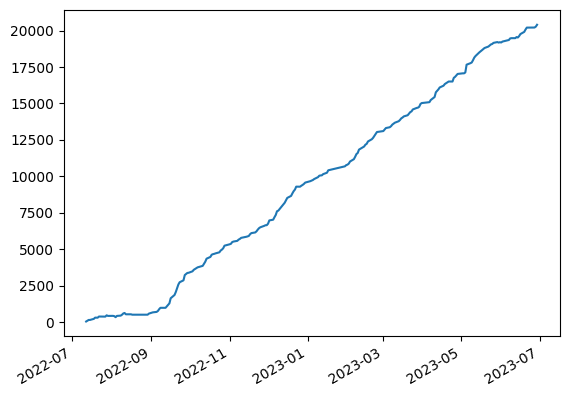

HCF 

362.22749344495327


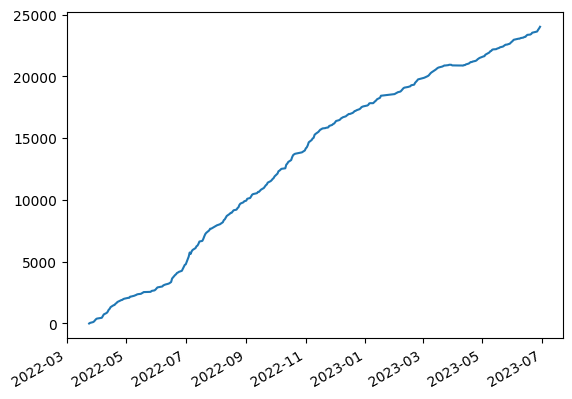

DBF 

189.35210464346198


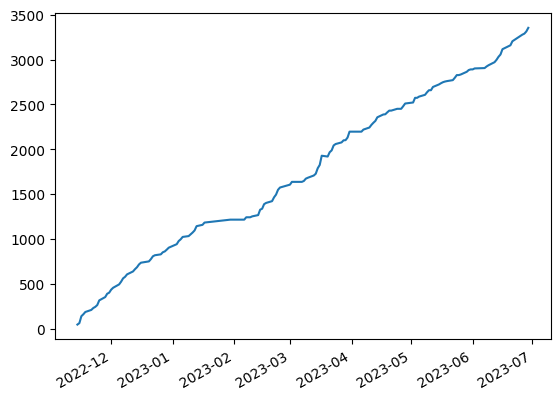

EHF 

249.03915814569


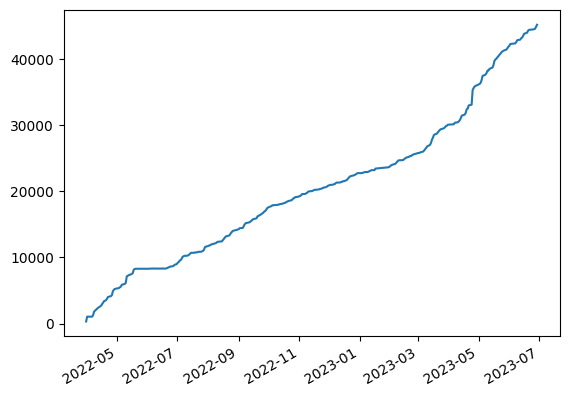

IPF 

335.32750460916816


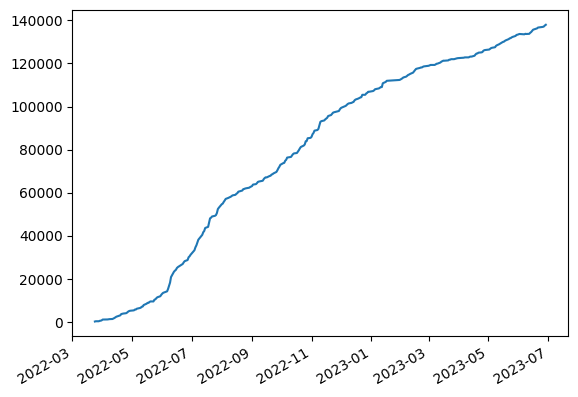

IIF 

219.93936752082314


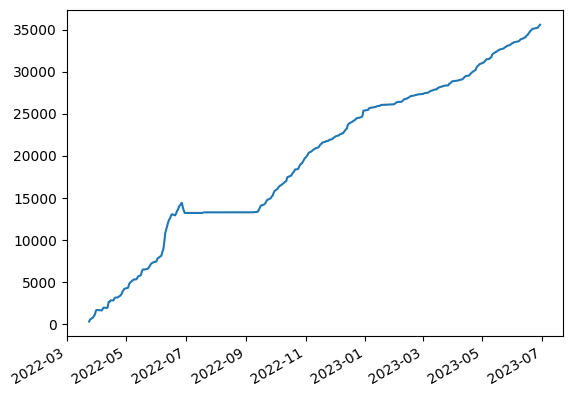

QXF 

137.01711480096463


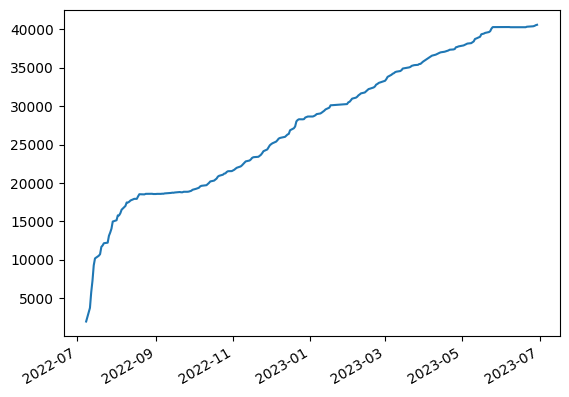

PEF 

151.78773677729552


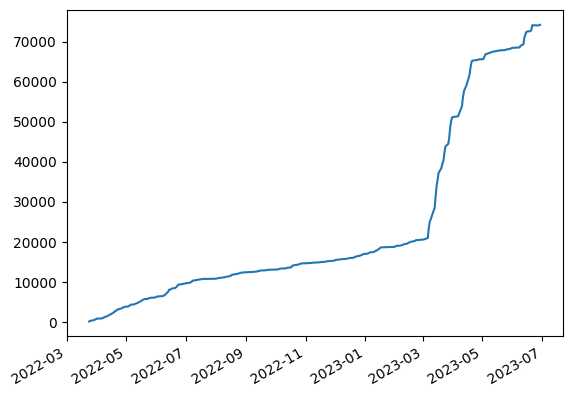

NAF 

354.8060143392444


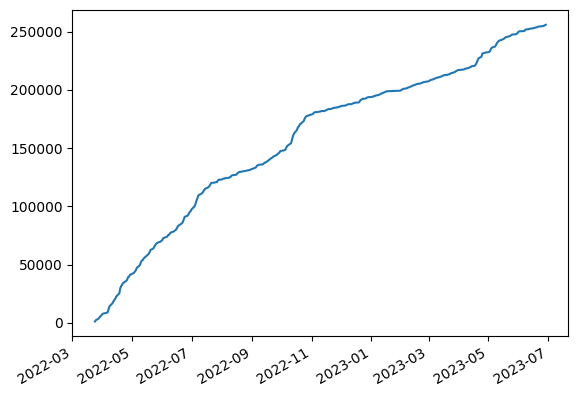

In [75]:
for name in pnl_dict.keys():
  cum_pnl = pnl_dict[name].cumsum()
  sd = pnl_dict[name].std()
  print(name, '\n')
  sharpe_ratio = cum_pnl[-1] / sd
  print(sharpe_ratio)
  cum_pnl.plot()
  plt.show()

# Add prediction model:

In [26]:
factor_path = '/content/drive/MyDrive/Colab Notebooks/Independent project_2023 Summer/FactorData/AllFactors/'
factor_list = ['RSI_5', 'bid1_ask1_ratio_futures', 'RSI_14', 'spread',
       'RSI_5_futures','bid1_ask1_ratio_stock']

In [79]:
pnl_dict_model = {}
for _ in tqdm(trading_pairs):

  spread_data = pd.read_csv(spread_path + _ + '.csv', index_col=0, parse_dates=True)
  spread = spread_data
  spread = spread.reset_index()
  spread['date'] = spread['time_stamp'].dt.date
  spread['time'] = spread['time_stamp'].dt.time
  spread = spread.set_index('time_stamp', drop = True)
  dates = list(set(pd.to_datetime(spread.date)))
  dates = sorted(dates)
  stock_data = pd.read_csv(data_path + 'stocks/' +trading_pairs[_] + '.csv', index_col=0, parse_dates=True)
  stock_data = stock_data.sort_index()
  futures_data = pd.read_csv(data_path + 'futures/' + _ + '.csv', index_col=0, parse_dates=True)
  #test = futures_data.loc[spread.index]
  futures_data = futures_data.sort_index()
  factor_data = pd.read_csv(factor_path + _ + '.csv', index_col=0, parse_dates=True)

  pnl_daily_model = {}

  #50 for test purpose
  #Time spot is end of 1 day before date(regarding threshold and mean), trade on date.
  for date in dates[50:-1]:
      #Using rolling mean as long term mean, data on the trading day is not included. To be tuned.
      rolling_window = 50
      train_date = valid_date_n_days_before(date, dates, rolling_window)
      end_date = valid_date_n_days_later(date, dates, 1)
      #After start_time all data is unknown.
      start_time = date + pd.DateOffset(hours=9,minute = 1)
      #Data on date not included.
      spread_historical_data = spread[train_date:date]
      #Long term mean and sd, for selecting threshold.
      sd = np.std(spread_historical_data['mid_quote'], axis=0)
      mean = spread_historical_data['mid_quote'].mean()

      upper = mean + 0.95 * sd
      lower = mean - 0.95 * sd

      #Stock and futures data
      stock_trade_data = stock_data[start_time:end_date]
      future_trade_data = futures_data[start_time:end_date]
      factor_trade_data = factor_data[start_time:end_date]
      spread_ = spread[start_time:end_date]

      #OLS model
      train_model_date = valid_date_n_days_before(date, dates, 3)
      factor_train_data = factor_data[train_model_date:date]
      X_train = factor_train_data[factor_list]
      y_train = factor_train_data['delta_1']
      #pred_lower = float(y_train.quantile(0.2))
      #pred_upper = float(y_train.quantile(0.8))
      pred_lower = 0
      pred_upper = 0

      model_ols = LinearRegression()
      model_ols.fit(X_train, y_train)

      # position 1 for long spread, -1 for short spread, 0 for no position
      position = 0

      # net position in dollar
      net_position = 0

      # shares of stock
      stock_position = 0

      # shares of future
      future_position = 0

      #We have all data before timestamp.
      timestamp = start_time + pd.DateOffset(minutes=1)
      next_row = spread_.loc[spread_.index >= timestamp].iloc[0]
      timestamp = next_row.name
      while timestamp <= spread_.index[-1]:

        #Liquidate all position sharply at end of day of stock.
        if timestamp == spread_.index[-1]:
            stock_row = stock_trade_data.loc[stock_trade_data.index >= timestamp].iloc[0]
            future_row = future_trade_data.loc[future_trade_data.index >= timestamp].iloc[0]

            #Position = 1 means shorted spread. Liquidate neees to long stock, sell futures.
            if position == 1:
                  #1 position of futures matches 2 position of stock.
                  #print("1",net_position)
                  #print(timestamp,stock_row.ask_1_average,stock_position,future_position,future_row.bid_1_average)
                  net_position = net_position + stock_position * stock_row.ask_1_average + future_position * future_row.bid_1_average * 2
                  #print("1 after",net_position)
            #Position = -1 means longed spread. Liquidate neees to sell stock, buy futures.
            if position == -1:
                  net_position = net_position + stock_position * stock_row.bid_1_average + future_position * future_row.ask_1_average * 2
            break

        #Latest data stored in row
        row = stock_trade_data.loc[timestamp]
        spread_latest = spread_.loc[timestamp].mid_quote
        future_last_row = (future_trade_data.loc[future_trade_data.index <= timestamp]).iloc[-1]

        factor_last_row = (factor_trade_data.loc[factor_trade_data.index <= timestamp]).iloc[-1]

        #Wait until next spread.
        future_next_row = future_trade_data.loc[spread_.loc[spread_.index > timestamp].iloc[0].name]
        stock_next_row = stock_trade_data.loc[future_next_row.name]

        pred_delta_spread = model_ols.predict(pd.DataFrame(factor_last_row[factor_list]).to_numpy().reshape(1,-1))
        #Open a position
        if stock_position == 0 and future_position == 0:
              if (spread_latest >= upper) & (pred_delta_spread <= pred_upper):
                  if stock_next_row['bid_1_total'] >=2:
                      position = 1
                      stock_position = stock_position - 2
                      future_position = future_position + 1
                      net_position = net_position + stock_next_row['bid_1_average'] * 2 - future_next_row['ask_1_average'] * 1 * 2
                      timestamp = future_next_row.name
                      continue
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  # print(next_row.name)
                  timestamp = next_row.name
              elif (spread_latest <= lower) & (pred_delta_spread >= pred_lower):
                  # print(1.2)
                  if stock_next_row['ask_1_total'] >=2:
                      position = -1
                      stock_position = stock_position + 2
                      future_position = future_position - 1
                      net_position = net_position - stock_next_row['ask_1_average'] * 2 + future_next_row['bid_1_average'] * 1 * 2
                      timestamp = future_next_row.name
                      continue
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  # print(next_row.name)
                  timestamp = next_row.name
              else:
                  # print(1.3)
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  # print(next_row.name)
                  timestamp = next_row.name

        #Already has a position
        else:
              if position == 1:
                  if (spread_latest <= mean) & (pred_delta_spread >= pred_lower):
                      while stock_position != 0 or future_position !=0:
                          if stock_position != 0:
                              remained = min(stock_position + stock_next_row['ask_1_total'], 0)
                              net_position = net_position - stock_next_row['ask_1_average'] * (remained - stock_position)
                              stock_position = remained
                          if future_position != 0:
                              remained = max(future_position - future_next_row['bid_1_total'], 0)
                              net_position = net_position + future_next_row['bid_1_average'] * (future_position - remained) * 2
                              future_position = remained
                          timestamp = future_next_row.name
                          if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                              break
                          stock_next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                          timestamp = stock_next_row.name
                          future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                      next_row = spread_.loc[spread_.index >= timestamp].iloc[0]
                      timestamp = next_row.name
                  else:
                      next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                      timestamp = next_row.name
              elif position == -1:
                  if (spread_latest >= mean) & (pred_delta_spread <= pred_upper):
                      while stock_position != 0 or future_position !=0:
                          if stock_position != 0:
                              remained = max(stock_position - stock_next_row['bid_1_total'], 0)
                              net_position = net_position + stock_next_row['bid_1_average'] * (stock_position - remained)
                              stock_position = remained
                          if future_position != 0:
                              remained = min(future_position + future_next_row['ask_1_total'], 0)
                              net_position = net_position - future_next_row['ask_1_average'] * (remained - future_position) * 2
                              future_position = remained
                          timestamp = future_next_row.name
                          if timestamp >= future_trade_data.index[-1] or timestamp >= stock_trade_data.index[-1]:
                              break
                          stock_next_row = stock_trade_data.loc[stock_trade_data.index > timestamp].iloc[0]
                          timestamp = stock_next_row.name
                          future_next_row = (future_trade_data.loc[future_trade_data.index > timestamp]).iloc[0]
                      next_row = spread_.loc[spread_.index >= timestamp].iloc[0]
                      timestamp = next_row.name
                  else:
                      next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                      timestamp = next_row.name
              else:
                  next_row = spread_.loc[spread_.index > timestamp].iloc[0]
                  timestamp = next_row.name
      pnl_daily_model[date] = -net_position
  # plot pnl
  pnl_model = pd.Series(pnl_daily_model)
  pnl_dict_model[_] = pnl_model

100%|██████████| 10/10 [43:06<00:00, 258.69s/it]


JBF 

sharpe_ratio:  156.5231706012839

sharpe_ratio_model:  156.00411794054813


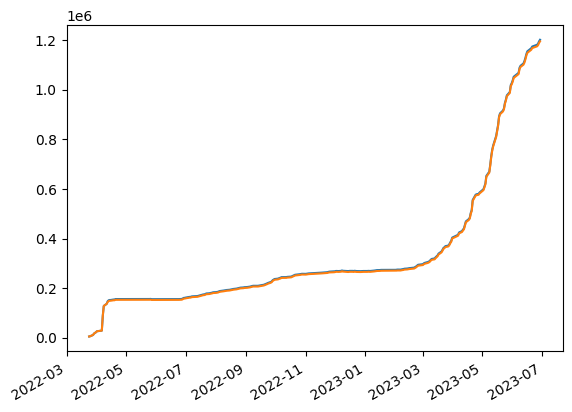

QWF 

sharpe_ratio:  261.49841938613895

sharpe_ratio_model:  259.5687474682798


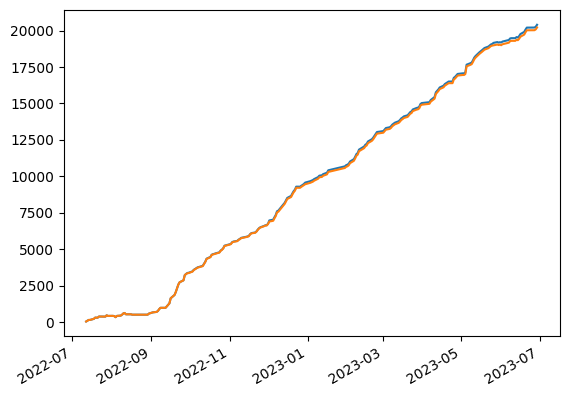

HCF 

sharpe_ratio:  362.22749344495327

sharpe_ratio_model:  361.82150462829554


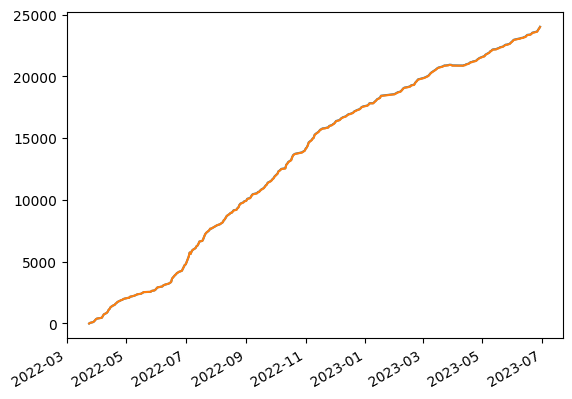

DBF 

sharpe_ratio:  189.35210464346198

sharpe_ratio_model:  190.46932381291424


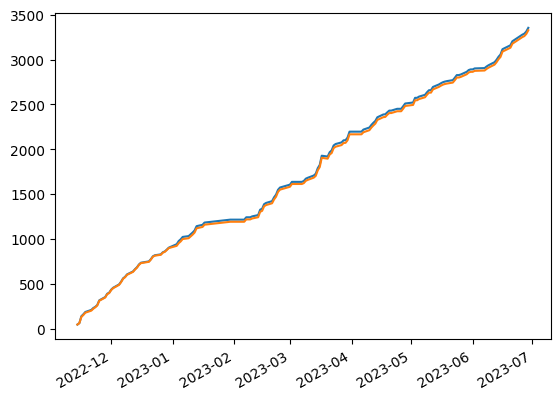

EHF 

sharpe_ratio:  249.03915814569

sharpe_ratio_model:  248.48914682510568


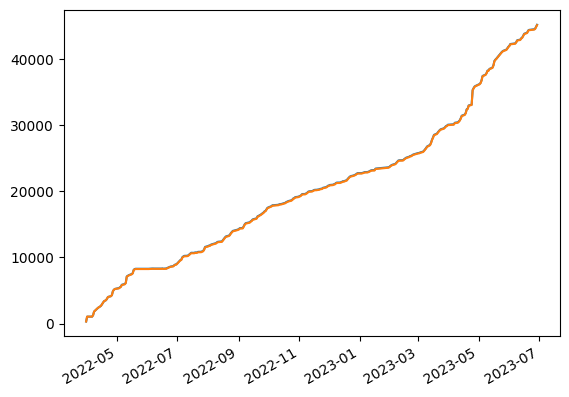

IPF 

sharpe_ratio:  335.32750460916816

sharpe_ratio_model:  334.64870763767885


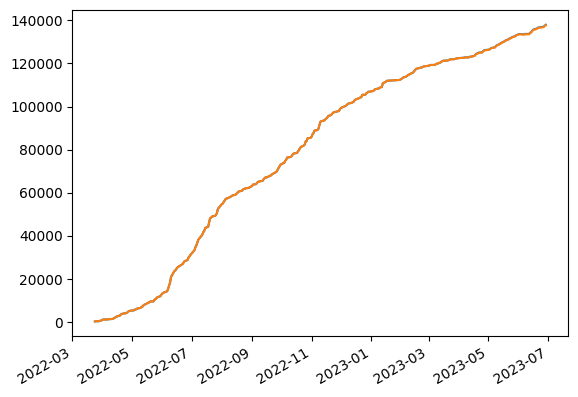

IIF 

sharpe_ratio:  219.93936752082314

sharpe_ratio_model:  222.8942361398021


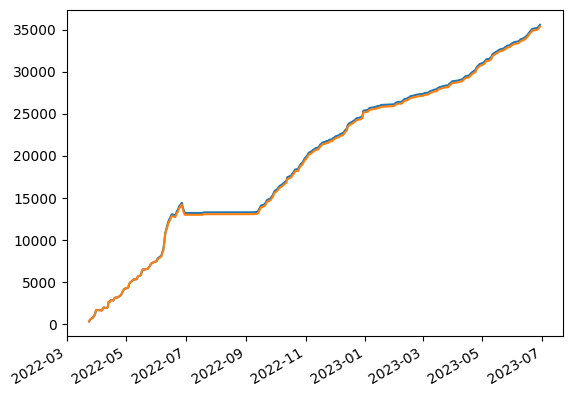

QXF 

sharpe_ratio:  137.01711480096463

sharpe_ratio_model:  136.2415798453039


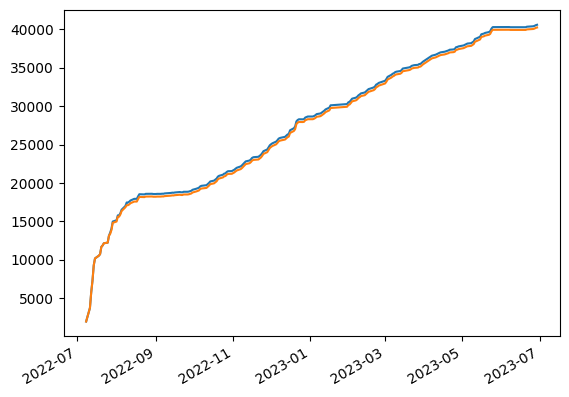

PEF 

sharpe_ratio:  151.78773677729552

sharpe_ratio_model:  153.68177483479496


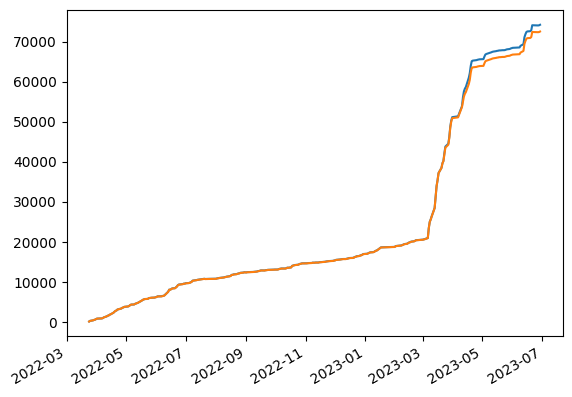

NAF 

sharpe_ratio:  354.8060143392444

sharpe_ratio_model:  355.04563183454684


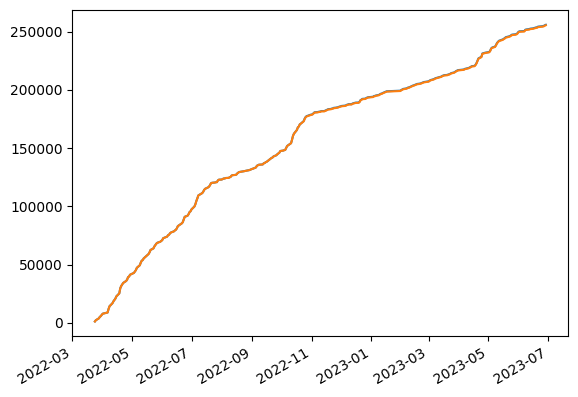

In [77]:
for name in pnl_dict.keys():
  cum_pnl_model = pnl_dict_model[name].cumsum()
  cum_pnl = pnl_dict[name].cumsum()
  sd_model = pnl_dict_model[name].std()
  sd = pnl_dict[name].std()
  print(name, '\n')
  sharpe_ratio = cum_pnl[-1] / sd
  sharpe_ratio_model = cum_pnl_model[-1] / sd_model
  print("sharpe_ratio: ",sharpe_ratio)
  print("\nsharpe_ratio_model: ",sharpe_ratio_model)
  cum_pnl.plot()
  cum_pnl_model.plot()
  plt.show()

JBF 

sharpe_ratio:  156.5231706012839

sharpe_ratio_model:  165.39798757743583


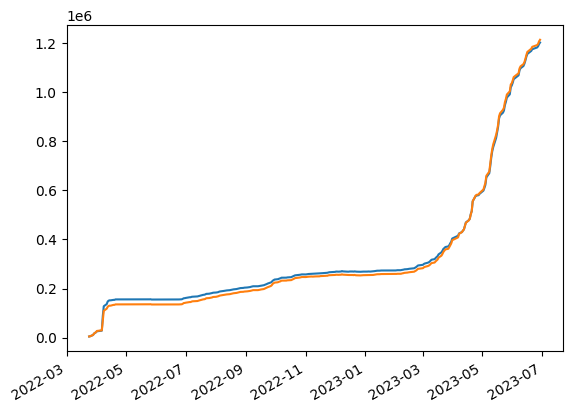

QWF 

sharpe_ratio:  261.49841938613895

sharpe_ratio_model:  247.83704364562524


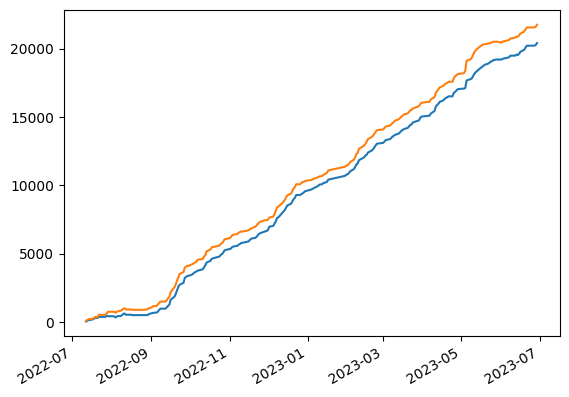

HCF 

sharpe_ratio:  362.22749344495327

sharpe_ratio_model:  365.1879667363593


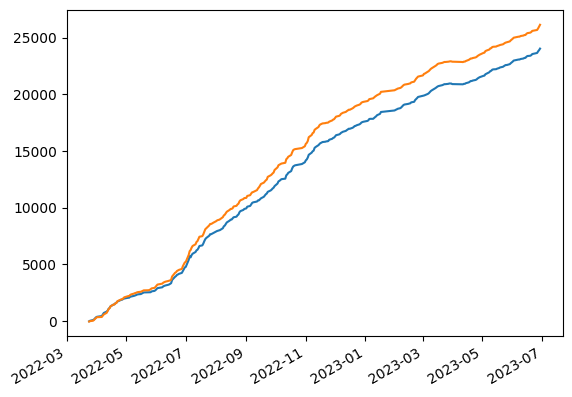

DBF 

sharpe_ratio:  189.35210464346198

sharpe_ratio_model:  198.58778859717262


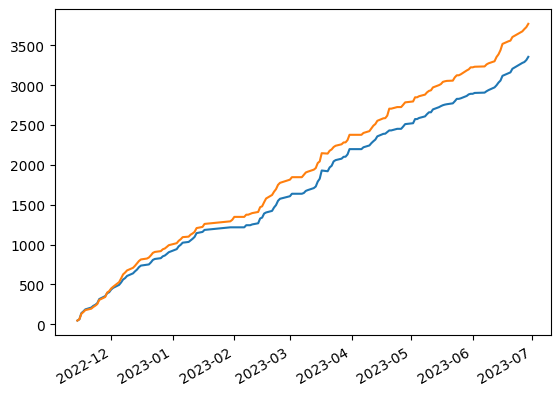

EHF 

sharpe_ratio:  249.03915814569

sharpe_ratio_model:  266.3870419409449


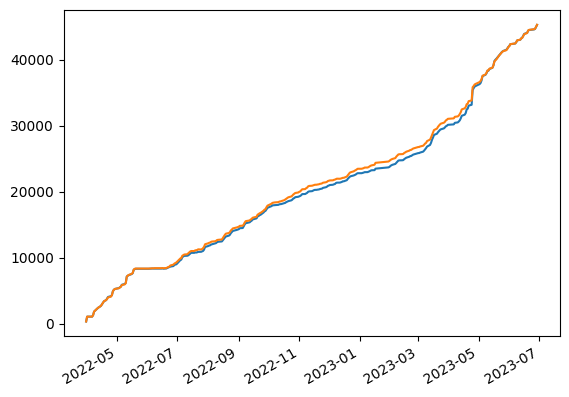

IPF 

sharpe_ratio:  335.32750460916816

sharpe_ratio_model:  335.6806462512263


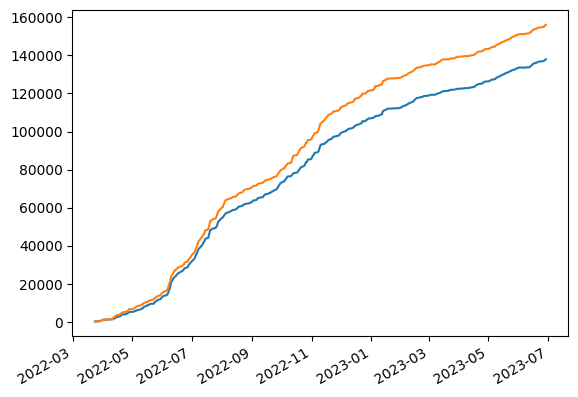

IIF 

sharpe_ratio:  219.93936752082314

sharpe_ratio_model:  218.12699885894168


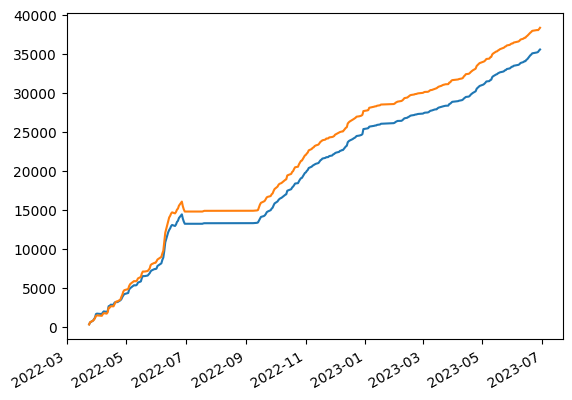

QXF 

sharpe_ratio:  137.01711480096463

sharpe_ratio_model:  137.0427742926987


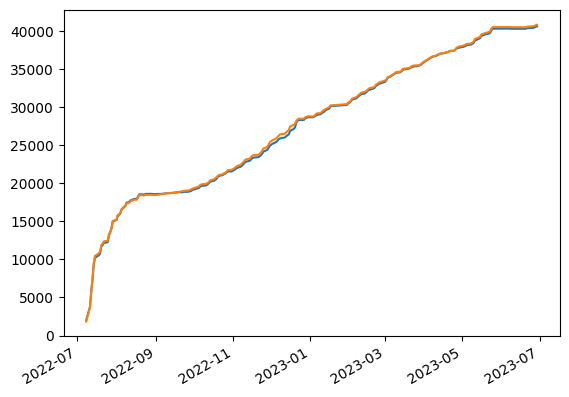

PEF 

sharpe_ratio:  151.78773677729552

sharpe_ratio_model:  155.37271436026236


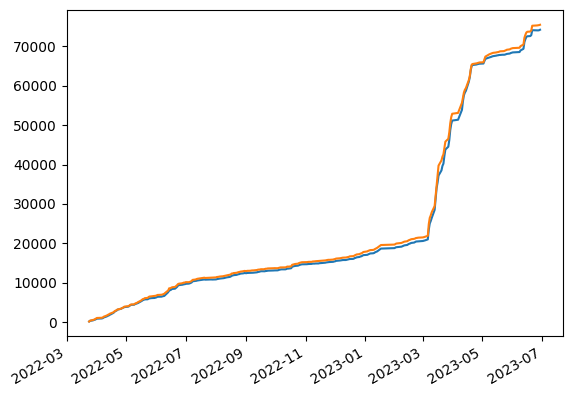

NAF 

sharpe_ratio:  354.8060143392444

sharpe_ratio_model:  373.09325236307495


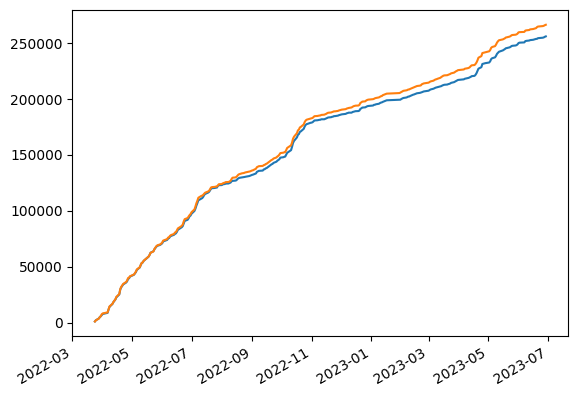

In [80]:
for name in pnl_dict.keys():
  cum_pnl_model = pnl_dict_model[name].cumsum()
  cum_pnl = pnl_dict[name].cumsum()
  sd_model = pnl_dict_model[name].std()
  sd = pnl_dict[name].std()
  print(name, '\n')
  sharpe_ratio = cum_pnl[-1] / sd
  sharpe_ratio_model = cum_pnl_model[-1] / sd_model
  print("sharpe_ratio: ",sharpe_ratio)
  print("\nsharpe_ratio_model: ",sharpe_ratio_model)
  cum_pnl.plot()
  cum_pnl_model.plot()
  plt.show()